# Analyze Zacros kMC trajectories data for O-Pt(111)

In [3]:
import numpy as np
from pathlib  import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
import zacros_functions as zf

In [4]:
# Time binning parameters
n_bins = 100

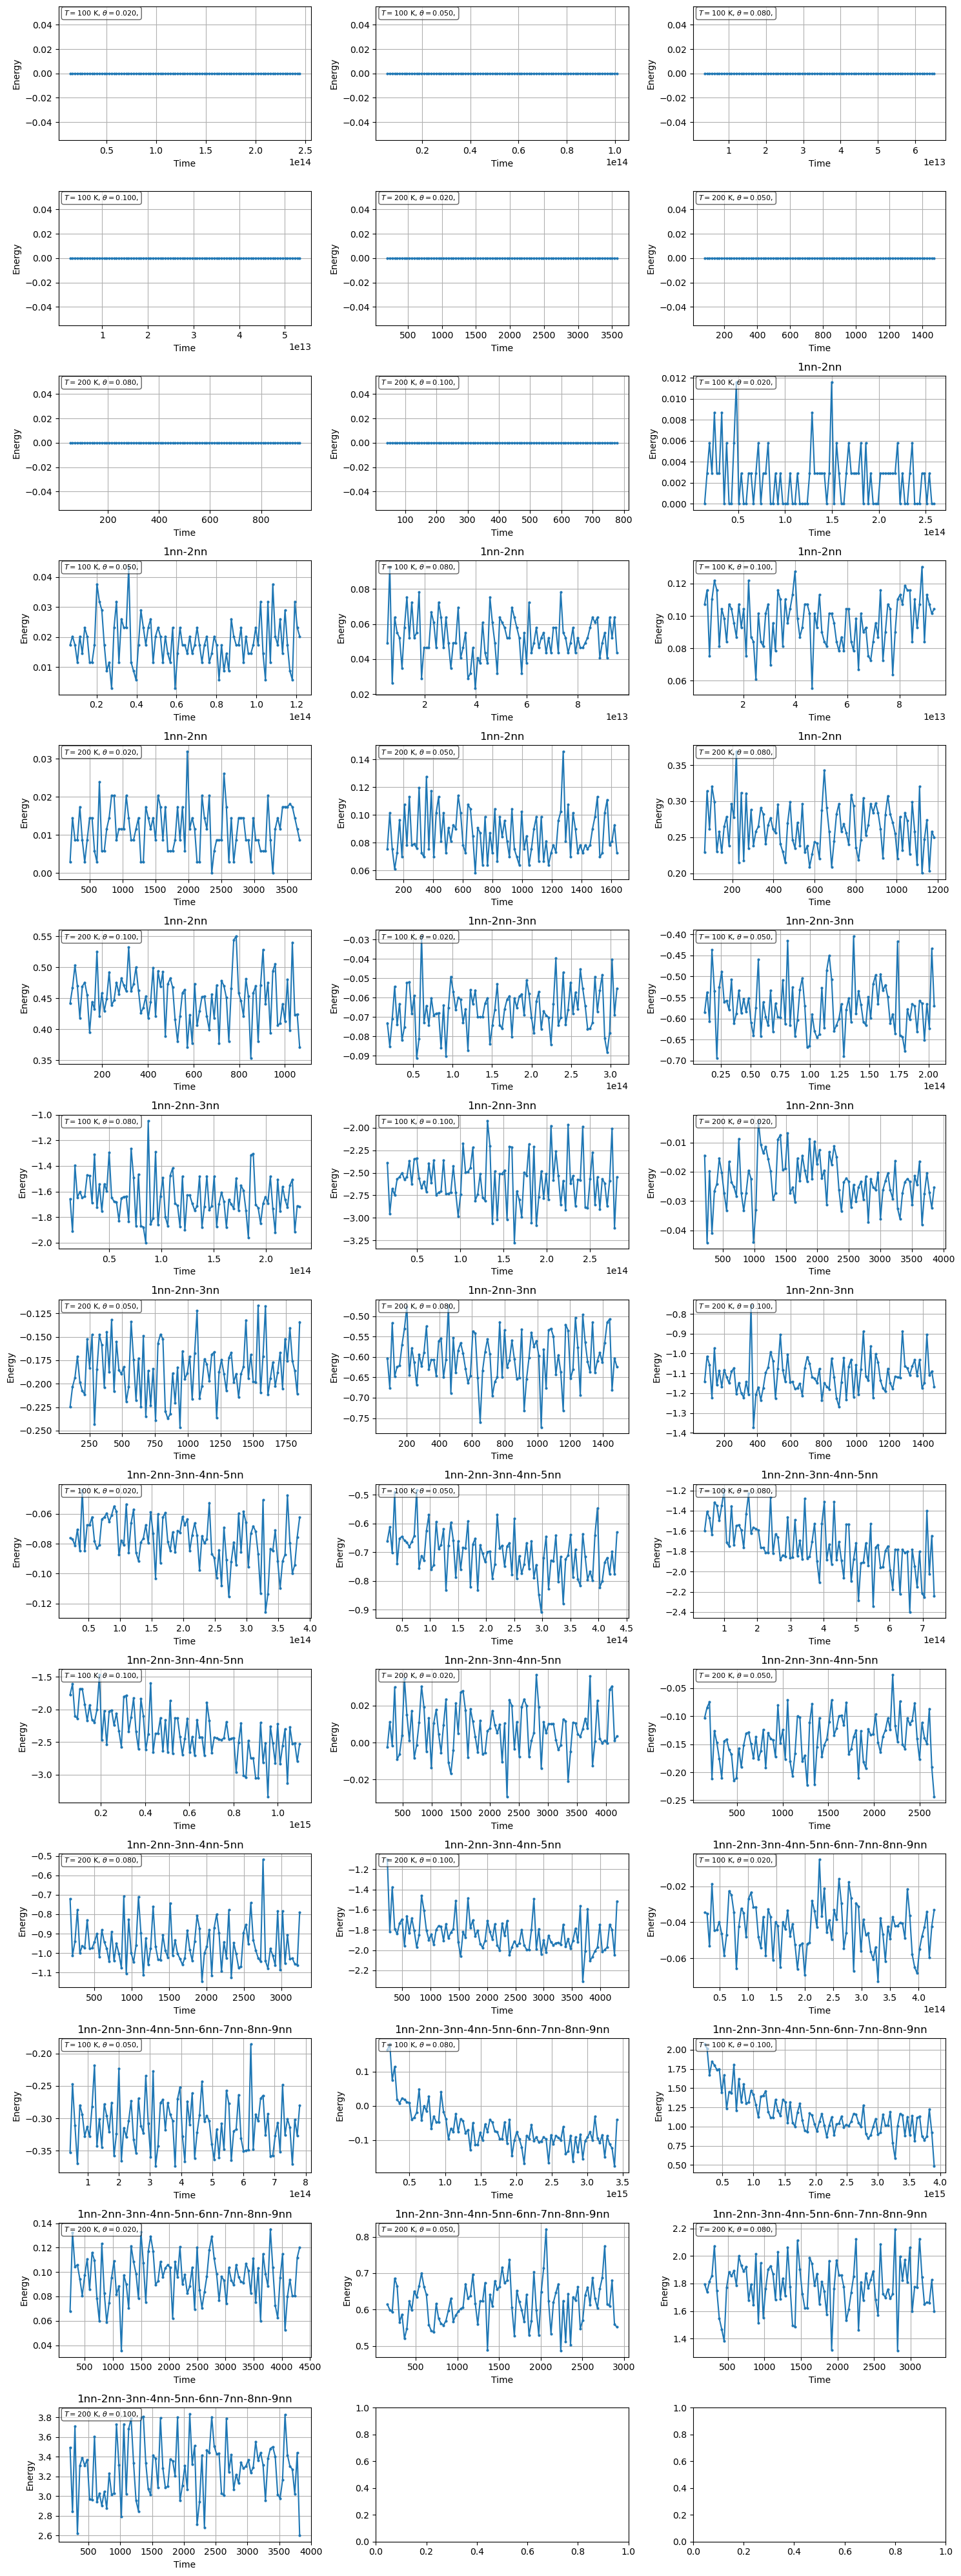

In [5]:
# Set directories and file names
# and get the starting point for equilibrium
# from the averaged energy plots

log_dir = Path.cwd() / 'zacros_calculations'
data_dir = log_dir / 'jobs'
results_dir = log_dir / 'results'
log_file = log_dir / 'jobs.log'

# Verify the file exists
if not log_file.exists():
    raise FileNotFoundError(f"Log file not found: {log_file}")

# Load json log file
with open(log_file, 'r') as f:
   log_header = f.readline().split()  # Read header
   log_entries = [json.loads(line) for line in f if line.strip()]

Path.mkdir(results_dir, exist_ok=True)
# Analyze data
run_dirs =[data_dir / str(entry[0]) for entry in log_entries]
temperatures = [entry[4] for entry in log_entries]
lat_size = [entry[2][0]*entry[2][1] for entry in log_entries]
n_ads = [entry[3][0] for entry in log_entries]
interactions = ['-'.join(entry[5][1:]) for entry in log_entries]
coverages = [n_ads[i]/lat_size[i] for i in range(len(n_ads))]

ncols = 3
fig, axes = plt.subplots(int(np.ceil(len(run_dirs)/ncols)), ncols, figsize=(15,40))

for ir,rundir in enumerate(run_dirs):

   # Check if the run was analyzed
   if (results_dir / f'{rundir.name}_{zf.en_file_suffix}').exists():
      # print(f' Using the processed data from {results_dir} for {rundir.name}')
      time_bin_centers, energy_hist = np.loadtxt(
                           results_dir / f'{rundir.name}_{zf.en_file_suffix}', unpack=True)

   else:
      # print(f' Processing trajectories from {rundir.name}...')
      # Get list of trajectories
      traj_files = list(rundir.rglob('history_output.txt'))

      # Get number of configurations and maximum kmc time for all trajectories
      nconfs = []
      end_time = np.inf
      for traj_file in traj_files:
         with open(traj_file) as f:
            for line in f: 
               if 'configuration' in line: 
                  confs = int(line.split()[1])
                  conf_time = float(line.split()[3])
         end_time = min(end_time, conf_time)
         nconfs.append(confs)

      time_bins   = np.linspace(0, end_time, n_bins+1)
      energy_hist = np.zeros(n_bins)
      for traj_file, confs in zip(traj_files,nconfs):

         time   = np.zeros(confs)
         energy = np.zeros(confs)

         # Get lattice-site coordinates
         try:
            lattice = np.loadtxt(traj_file.parent / 'lattice_output.txt', usecols=(1,2),skiprows=2)
            nsites  = len(lattice)
         except Exception:
            raise FileNotFoundError('lattice_output.txt not found in ' + str(traj_file.parent))
         
         # Get adsorbate positions
         counter = 0
         with open(traj_file) as f:
            for line in f:
                  if 'configuration' in line:
                     time[counter]   = float(line.split()[3])
                     energy[counter] = float(line.split()[5])
                     counter += 1

         # Create average energy histogram with n_bins
         for i in range(confs):
            bin_index = np.digitize(time[i], time_bins,right=False) - 1
            if bin_index < confs: energy_hist[bin_index] += energy[i]

      energy_hist /= len(nconfs)
      # Save processed data
      time_bin_centers = 0.5 * (time_bins[:-1] + time_bins[1:])
      np.savetxt(results_dir / f'{rundir.name}_{zf.en_file_suffix}', 
                 np.column_stack((time_bin_centers, energy_hist)), 
                 header='Time_s Energy_eV')

   # Plot energy as function of time using subplots
   ax = axes[ir//ncols, ir%ncols]
   ax.plot(time_bin_centers[5:], energy_hist[5:], marker='o', linestyle='-', markersize=2)
   ax.set_xlabel('Time')
   ax.set_ylabel('Energy')
   ax.set_title(f'{interactions[ir]}')
   ax.text(0.02, 0.98, fr'$T={temperatures[ir]}$ K, $\theta={coverages[ir]:.3f}$, ',
             transform=ax.transAxes,
             va='top', ha='left',
             fontsize=8,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

   ax.grid()

plt.tight_layout()
plt.show()

Radial Distribution Functions

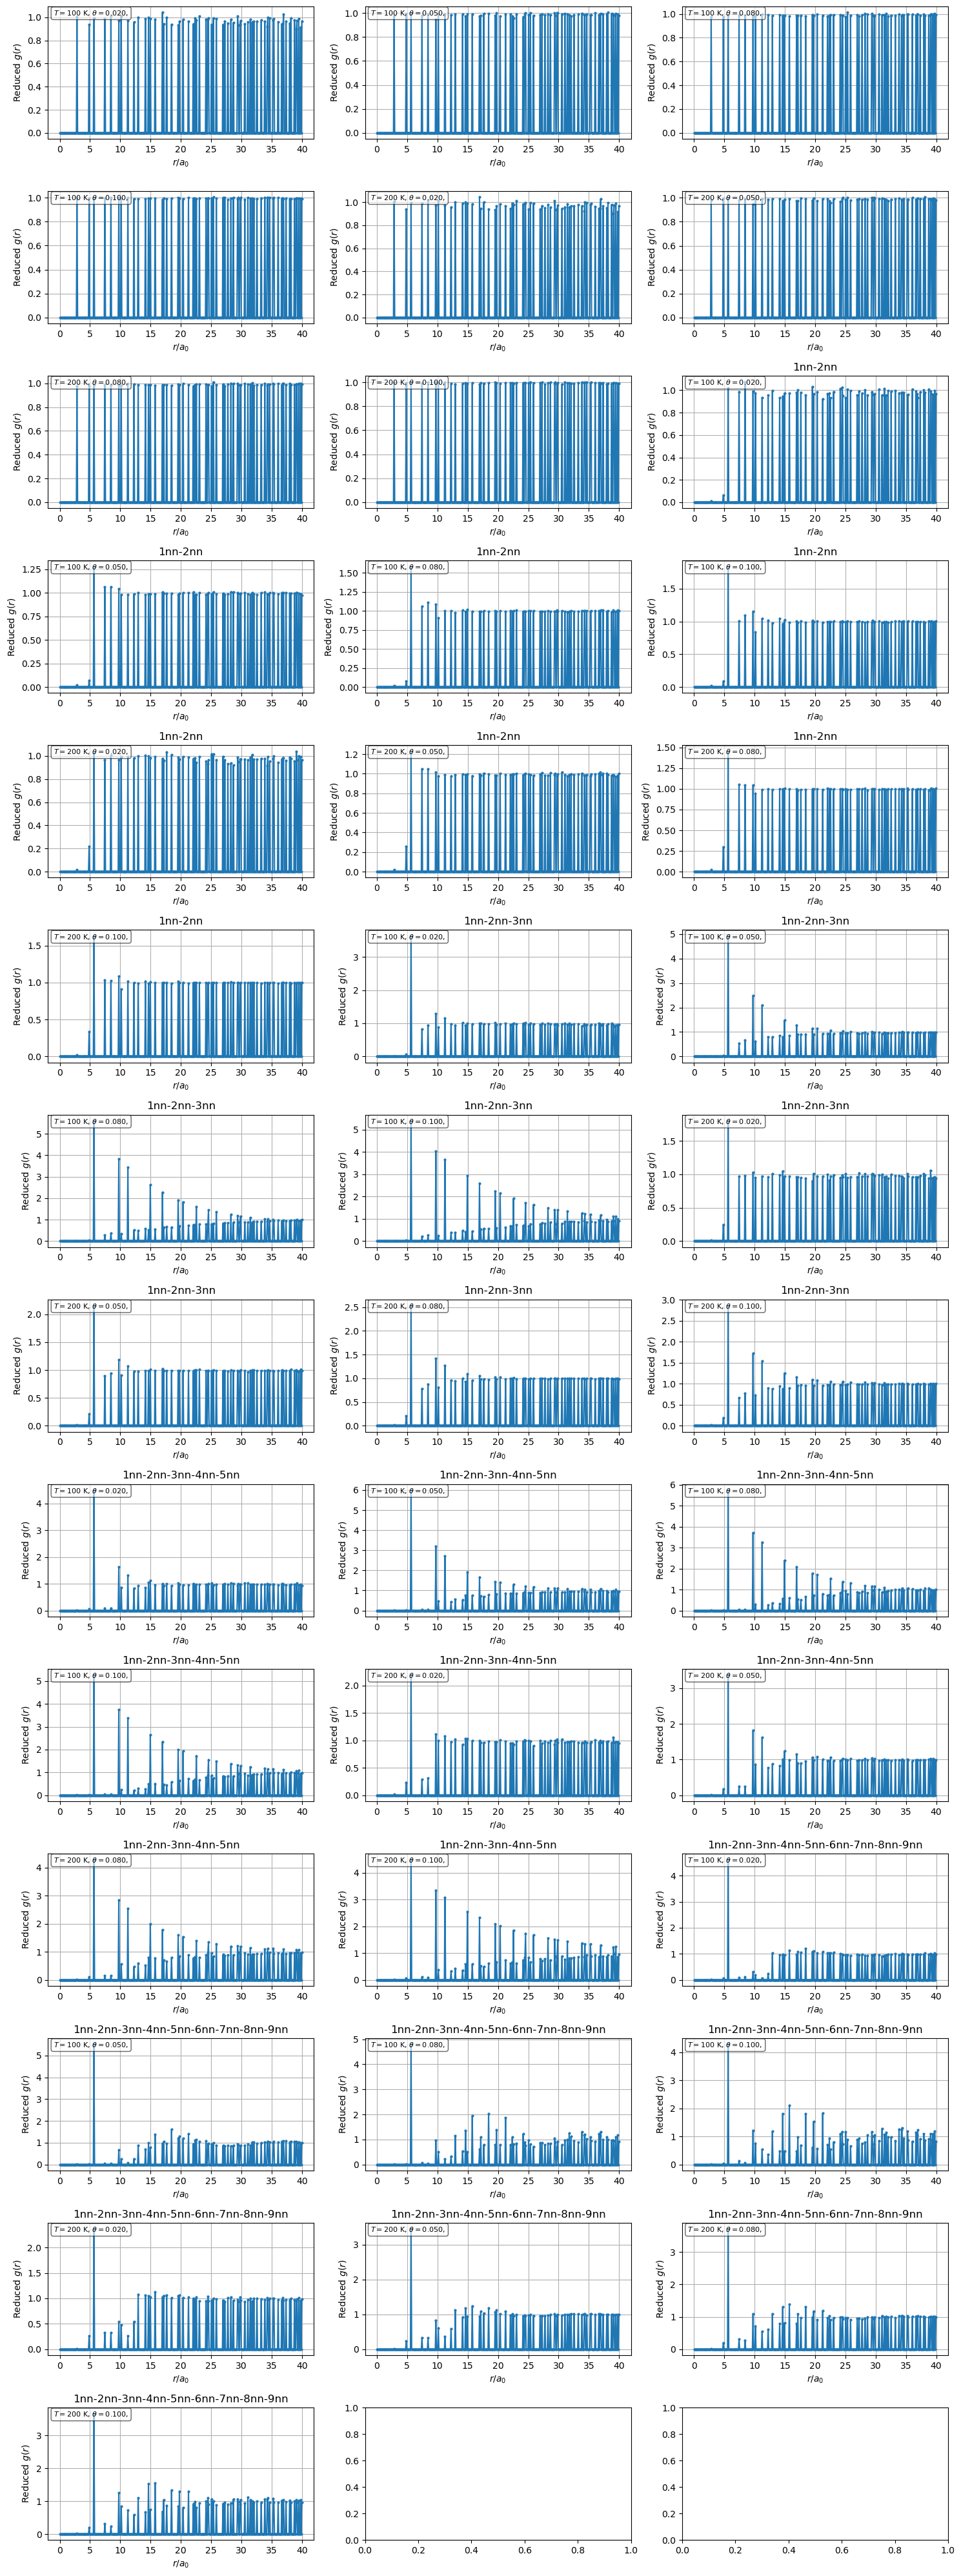

In [ ]:
# Set the starting point for equilibrium from the averaged energy plots
fraction_eq = 0.5
# Consider extracting the lattice constant from zacros input files
lattice_constant = 2.821135
# RDF parameters
r_max = 40.0
dr    = 0.1
nbins = int(np.ceil(r_max / dr))

ncols = 3
fig_rdf, axes_rdf = plt.subplots(int(np.ceil(len(run_dirs)/ncols)), ncols, figsize=(15,40))

start_ir = 0
for irr,rundir in enumerate(run_dirs[start_ir:]):
   ir = irr + start_ir

   # Check if the run was analyzed
   if (results_dir / f'{rundir.name}_{zf.rdf_file_suffix}').exists():
      #print(f' Using the processed data from {results_dir} for {rundir.name}')
      r, g_avg = np.loadtxt(results_dir / f'{rundir.name}_{zf.rdf_file_suffix}', unpack=True)

   else:

      print(f' Processing trajectories from {rundir.name}...')
      # Get list of trajectories
      traj_files = list(rundir.rglob('history_output.txt'))

      # Get number of configurations
      nconfs = []
      for traj_file in traj_files:
         with open(traj_file) as f:
            for line in f: 
               if 'configuration' in line: 
                  confs = int(line.split()[1])
         nconfs.append(confs)

      g_avg = np.zeros(nbins)
      for traj_file, confs in zip(traj_files,nconfs):

         # Get lattice-site coordinates
         try:
            lattice = np.loadtxt(traj_file.parent / 'lattice_output.txt', usecols=(1,2),skiprows=2)
            with open(traj_file.parent / 'lattice_output.txt') as f:
               v1 = np.array(f.readline().split()[1:3], dtype=float)
               v2 = np.array(f.readline().split()[1:3], dtype=float)
            nsites  = len(lattice)
         except Exception:
            raise FileNotFoundError('lattice_output.txt not found in ' + str(traj_file.parent))
         
         # Get reference RDF for full coverage
         r, g_ref = zf.rdf([lattice], 1, v1, v2, 
                        lattice_constant=lattice_constant, r_max=r_max, dr=dr,
                        plot=False)

         # Get adsorbate positions
         ads_coords = zf.get_xy(traj_file.parent / 'lattice_input.dat')        

         # Get RDF averaged over configurations in trajectory
         r, g_traj = zf.rdf(ads_coords[:-int(fraction_eq*len(ads_coords))], 
                        coverages[ir], v1, v2, 
                        lattice_constant=lattice_constant, r_max=r_max, dr=dr,
                        g_ref=g_ref, plot=False)
         g_avg += g_traj / len(traj_files)

      # Save processed data
      np.savetxt(results_dir / f'{rundir.name}_{zf.rdf_file_suffix}', 
                 np.column_stack((r, g_avg)), 
                 header='r_Angstroem rdf_au')

   # Plot rdf using subplots
   ax = axes_rdf[ir//ncols, ir%ncols]
   ax.plot(r, g_avg, marker='o', linestyle='-', markersize=2)
   ax.set_xlabel(r'$r/a_0$')
   ax.set_ylabel('Reduced $g(r)$')
   ax.set_title(f'{interactions[ir]}')
   ax.text(0.02, 0.98, fr'$T={temperatures[ir]}$ K, $\theta={coverages[ir]:.3f}$, ',
             transform=ax.transAxes,
             va='top', ha='left',
             fontsize=8,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

   ax.grid()


fig_rdf.tight_layout()
#fig_rdf.show()

Cluster Size and Circularity Distributions

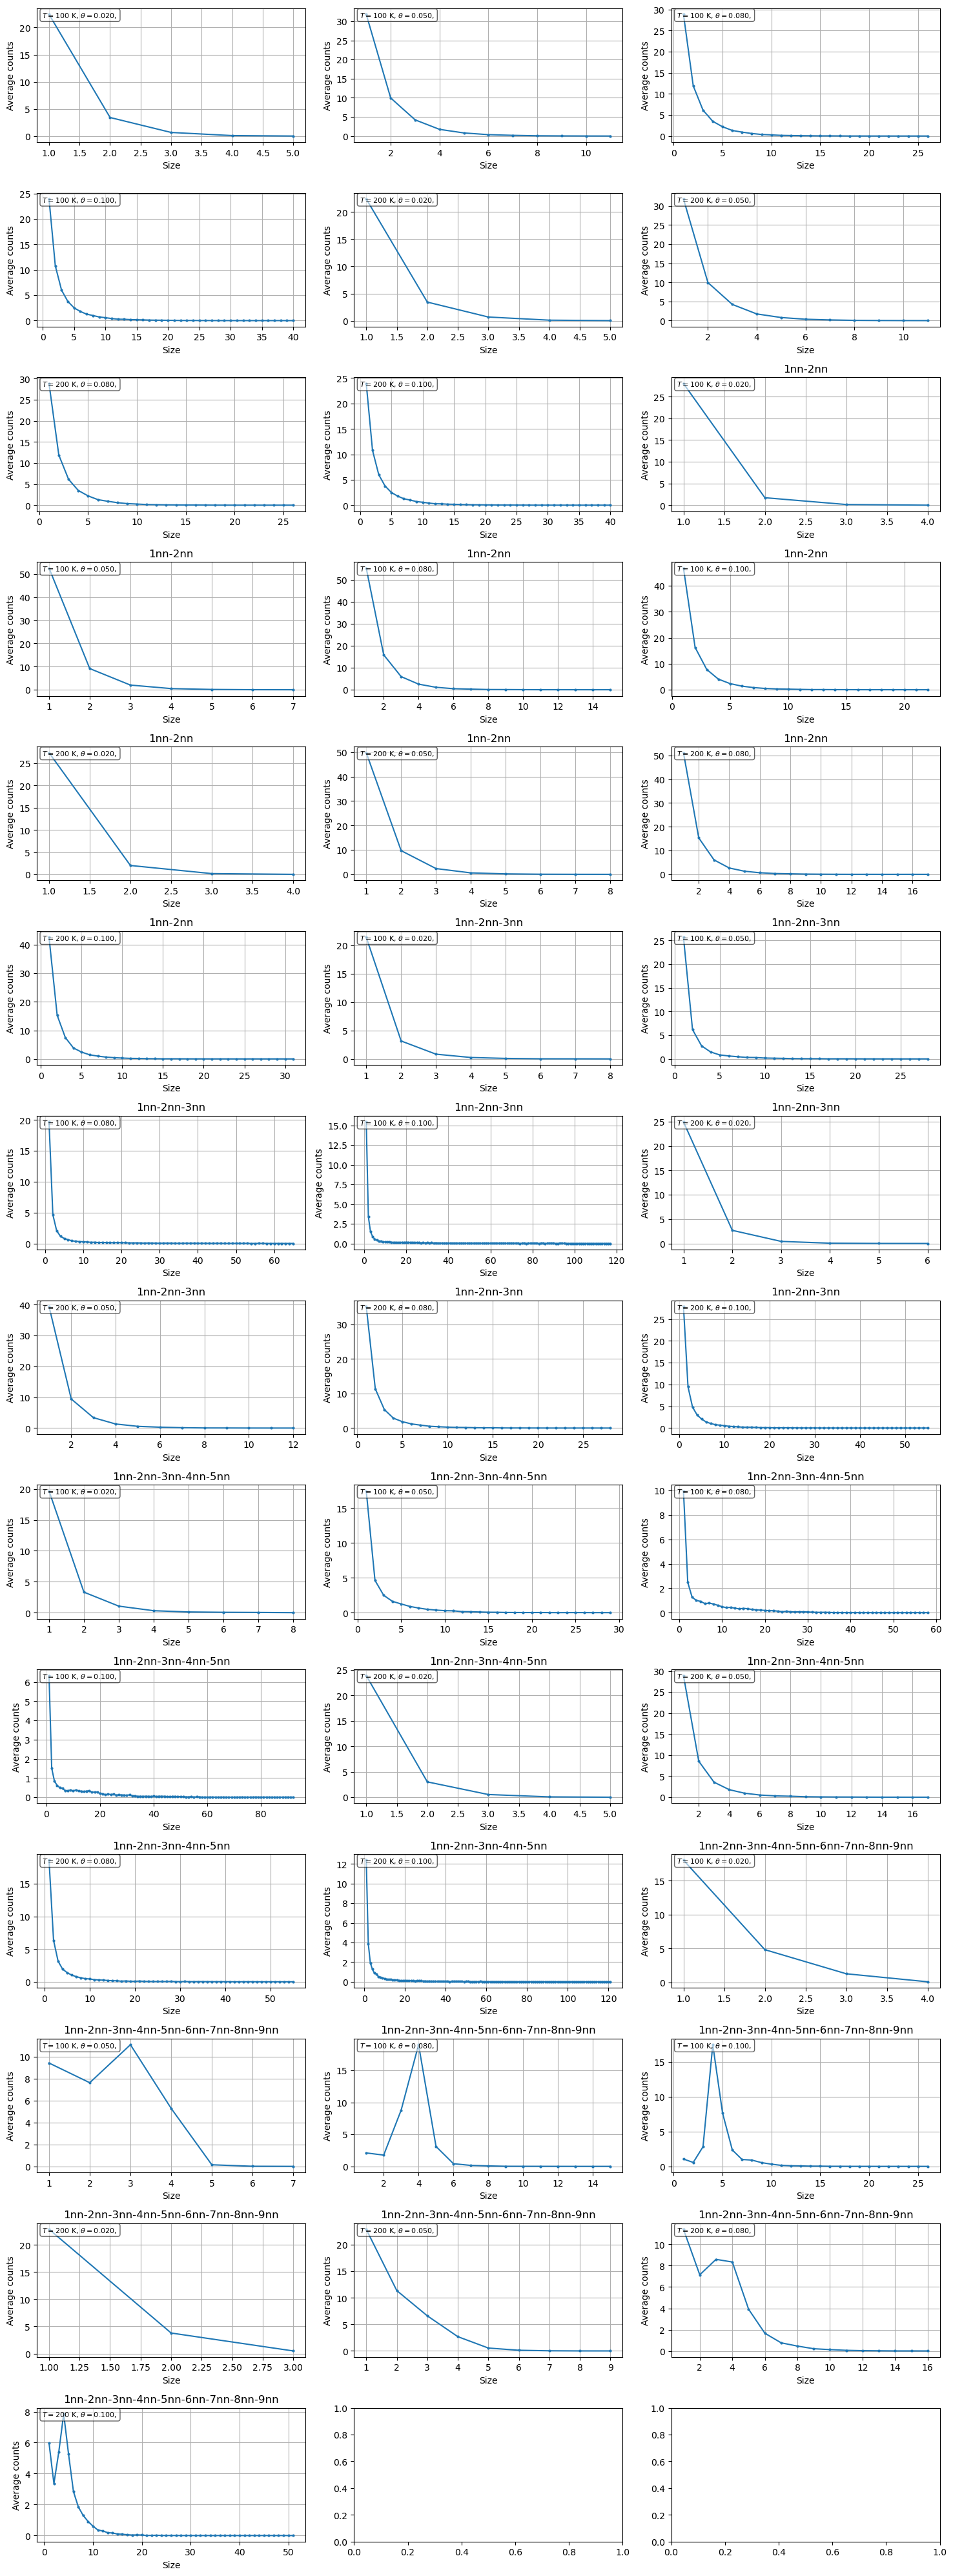

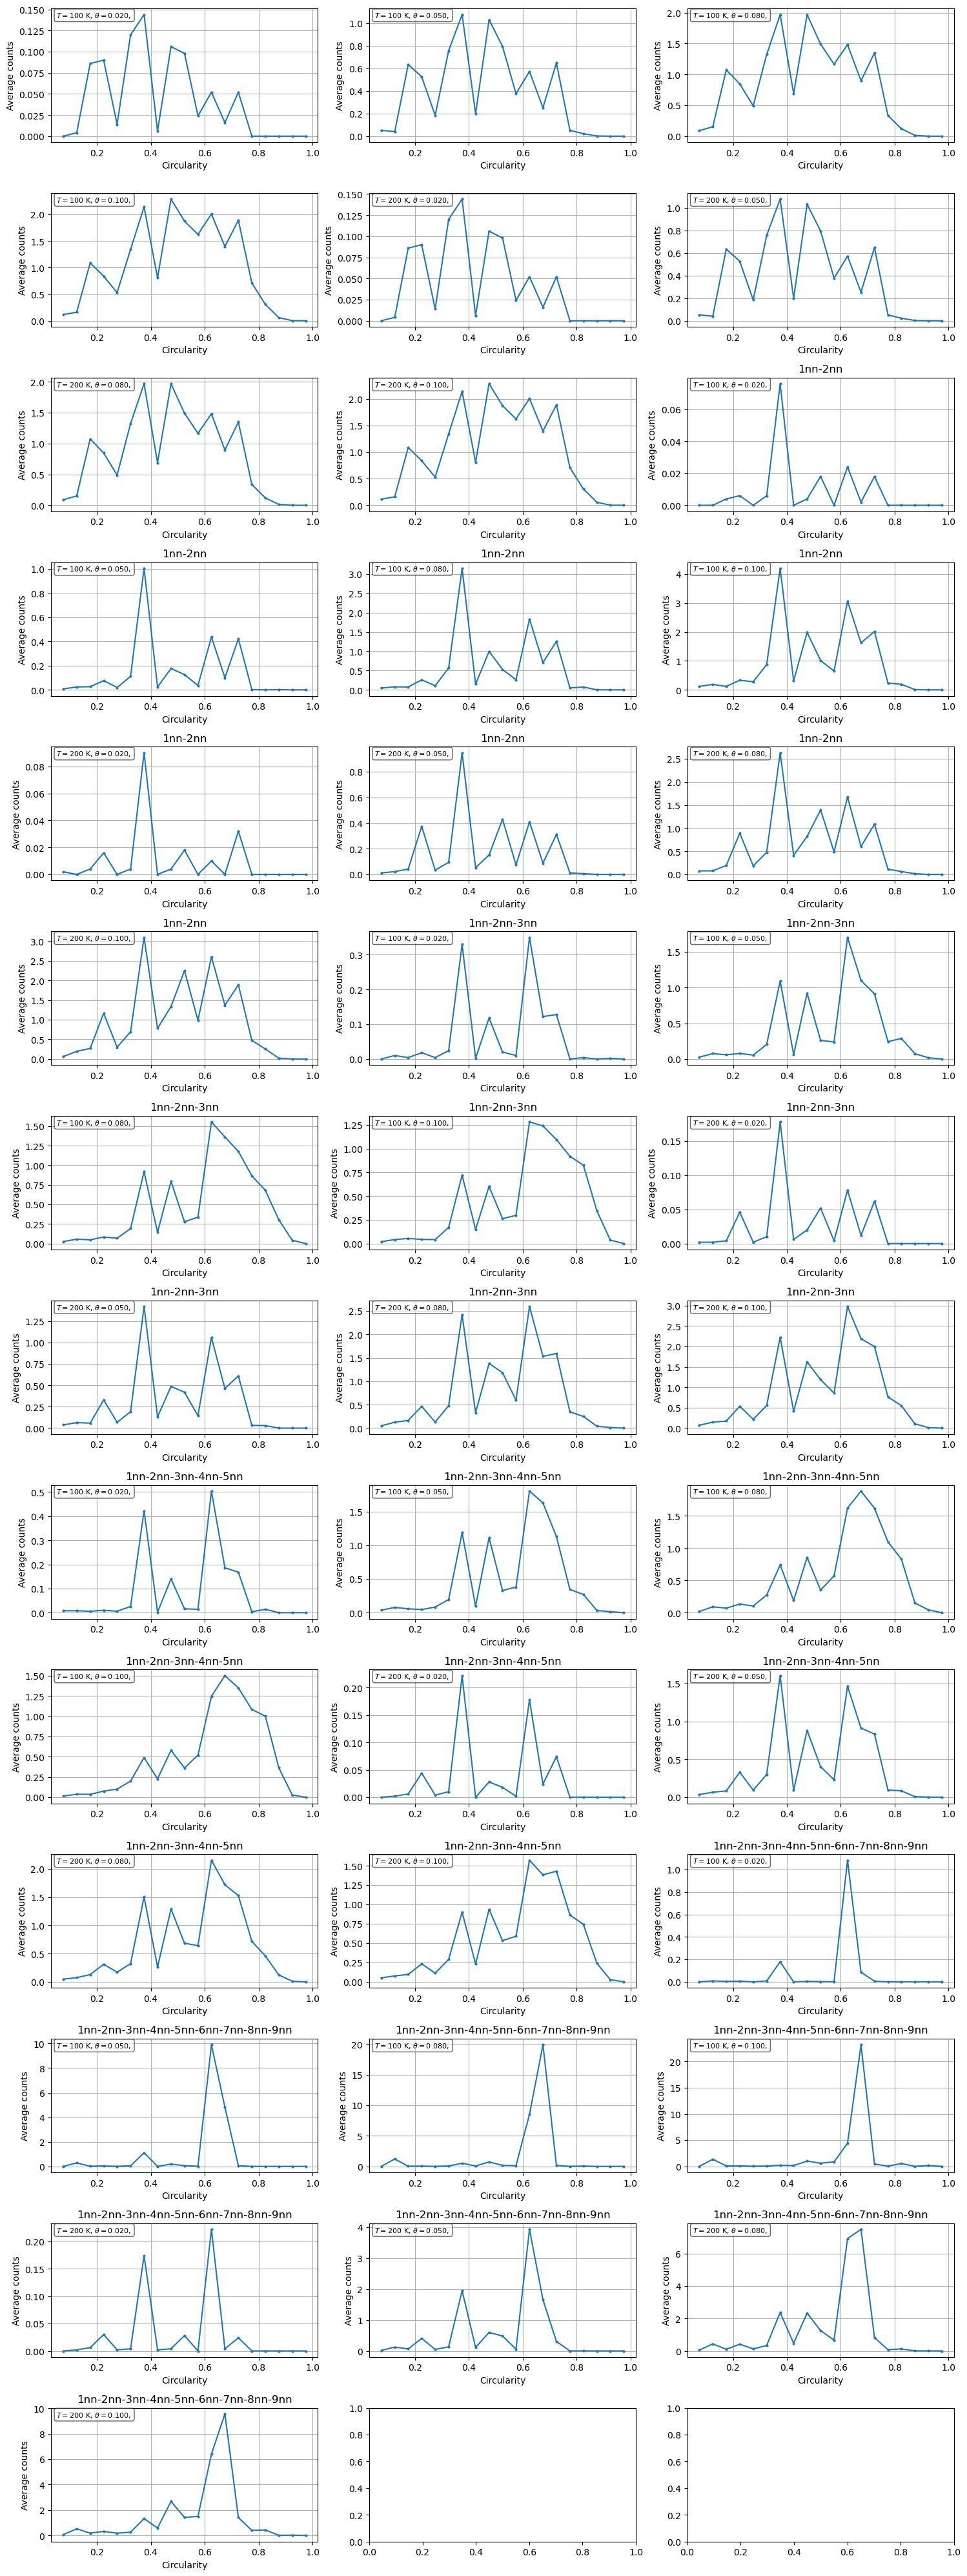

In [8]:
# Set the starting point for equilibrium from the averaged energy plots
fraction_eq = 0.5
# Consider extracting the lattice constant from zacros input files
lattice_constant = 2.821135
# Cluster circularity parameters
nbins_circ = 20

ncols = 3
fig_csd, axes_csd = plt.subplots(int(np.ceil(len(run_dirs)/ncols)), ncols, figsize=(15,40))
fig_ccd, axes_ccd = plt.subplots(int(np.ceil(len(run_dirs)/ncols)), ncols, figsize=(15,40))

start_ir = 0
for irr,rundir in enumerate(run_dirs[start_ir:]):
   ir = irr + start_ir

   # Check if the run was analyzed
   if (results_dir / f'{rundir.name}_{zf.csd_file_suffix}').exists():
      #print(f' Using the processed data from {results_dir} for {rundir.name}')
      csd_xs1, csd_avg1 = np.loadtxt(results_dir / f'{rundir.name}_{zf.csd_file_suffix}', unpack=True)
      ccd_x, ccd_avg    = np.loadtxt(results_dir / f'{rundir.name}_{zf.ccd_file_suffix}', unpack=True)

   else:

      print(f' Processing trajectories from {rundir.name}...')
      # Get list of trajectories
      traj_files = list(rundir.rglob('history_output.txt'))

      # Get number of configurations
      nconfs = []
      for traj_file in traj_files:
         with open(traj_file) as f:
            for line in f: 
               if 'configuration' in line: 
                  confs = int(line.split()[1])
         nconfs.append(confs)

      # Get number of lattice sites from the first trajectory
      try:
         lattice = np.loadtxt(traj_files[0].parent / 'lattice_output.txt', usecols=(1,2),skiprows=2)
         nsites  = len(lattice)
      except Exception:
         raise FileNotFoundError('lattice_output.txt not found in ' + str(traj_files[0].parent))
     
      csd_xs  = np.zeros(nsites)
      csd_avg = np.zeros(nsites)
      ccd_avg = np.zeros(nbins_circ)
      for traj_file, confs in zip(traj_files,nconfs):

         # Get lattice-site coordinates
         try:
            lattice = np.loadtxt(traj_file.parent / 'lattice_output.txt', usecols=(1,2),skiprows=2)
            with open(traj_file.parent / 'lattice_output.txt') as f:
               v1 = np.array(f.readline().split()[1:3], dtype=float)
               v2 = np.array(f.readline().split()[1:3], dtype=float)
            nsites  = len(lattice)
         except Exception:
            raise FileNotFoundError('lattice_output.txt not found in ' + str(traj_file.parent))
         
         # Get adsorbate positions
         ads_coords = zf.get_xy(traj_file.parent / 'lattice_input.dat')        

         # Get cluster size distribution
         csd_x, csd_y, ccd_x, ccd_y = zf.cluster_circularity_periodic_avg(
                                       ads_coords[:-int(fraction_eq*len(ads_coords))], 
                                       v1, v2, 2.01*lattice_constant, nbins=nbins_circ)
         
         # Accumulate cluster size distributions accounting for different lengths
         csd_xs[:len(csd_x)] = csd_x
         csd_avg[:len(csd_y)] += csd_y / len(traj_files)

         ccd_avg += ccd_y / len(traj_files)

      # Cut off zero entries from csd
      last_nz = np.flatnonzero(csd_xs)[-1] + 1

      csd_xs1 = csd_xs[:last_nz]
      csd_avg1 = csd_avg[:last_nz]
      # Save processed data
      np.savetxt(results_dir / f'{rundir.name}_{zf.csd_file_suffix}', 
                 np.column_stack((csd_xs1, csd_avg1)), 
                 header='size average_counts')
      np.savetxt(results_dir / f'{rundir.name}_{zf.ccd_file_suffix}', 
                 np.column_stack((ccd_x, ccd_avg)), 
                 header='circularity average_counts')

   # Plot csd using subplots
   ax = axes_csd[ir//ncols, ir%ncols]
   ax.plot(csd_xs1, csd_avg1, marker='o', linestyle='-', markersize=2)
   ax.set_xlabel(r'Size')
   ax.set_ylabel('Average counts')
   ax.set_title(f'{interactions[ir]}')
   ax.text(0.02, 0.98, fr'$T={temperatures[ir]}$ K, $\theta={coverages[ir]:.3f}$, ',
             transform=ax.transAxes,
             va='top', ha='left',
             fontsize=8,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

   ax.grid()

   # Plot ccd using subplots
   ax = axes_ccd[ir//ncols, ir%ncols]
   ax.plot(ccd_x[1:], ccd_avg[1:], marker='o', linestyle='-', markersize=2)
   ax.set_xlabel(r'Circularity')
   ax.set_ylabel('Average counts')
   ax.set_title(f'{interactions[ir]}')
   ax.text(0.02, 0.98, fr'$T={temperatures[ir]}$ K, $\theta={coverages[ir]:.3f}$, ',
             transform=ax.transAxes,
             va='top', ha='left',
             fontsize=8,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

   ax.grid()

fig_csd.tight_layout()
#fig_csd.show()
fig_ccd.tight_layout()
#fig_ccd.show()

In [6]:
df = pd.DataFrame({
    'dir': run_dirs,
    'temperature': temperatures,
    'latsize': lat_size,
    'nads': n_ads,
    'int': interactions,
    'cov': coverages
})

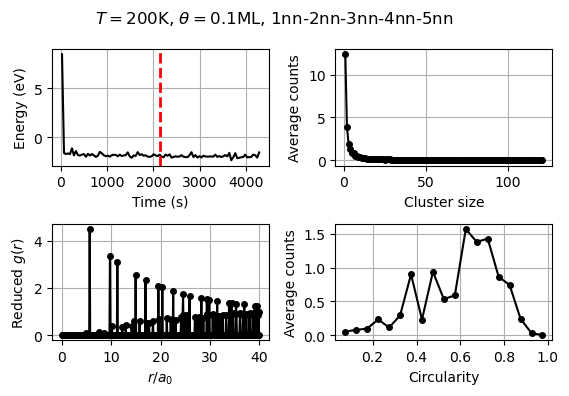

In [12]:
rundir = zf.plot_avgs(df, temperature=200, cov = 0.1, int='5nn',fraction_eq=fraction_eq,figsize=(6,4))

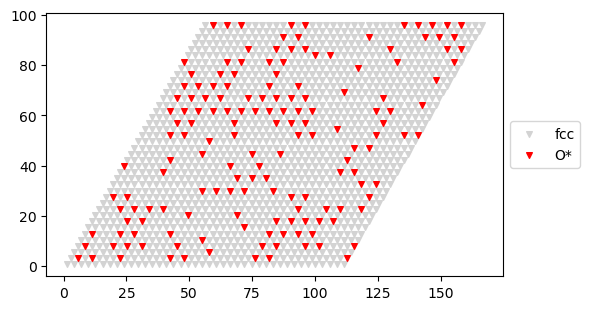

In [13]:
zf.lattice_plot(rundir / 'traj_1/lattice_input.dat',figsize=(6,4))

In [82]:
def get_xy(fname):
   try:
      return np.loadtxt(fname, unpack=True)
   except :
      return None,None

def plot_csds(df, temperature=[300], cov=[0.01], ints=[''], overlay=True):

   # Get the number of data to plot
   data = []
   cond_list = []
   for T in temperature:
      for c in cov:
         for i in ints:

            # Get df rows satisfying the conditions
            conditions = (df['int'] == i) & (df['temperature'] == T) & (df['cov'] == c)
            # Ignore not existing data
            if len(df[conditions]) > 0:
               # Get run data dir name
               rundir = df[conditions].dir.iloc[0] 
               fname = rundir.parent.parent / 'results' / f'{rundir.name}_{zf.csd_file_suffix}'
               x, y = get_xy(fname)
               if x is not None: 
                  data.append([x, y])
                  cond_list.append([T, c, i])

   if overlay:
      nrows, ncols = 1, 1
      figsize = (8,4)
   else:
      ncols = 3
      nrows = int(np.ceil(len(data)/ncols))
      figsize = (15,4*nrows)

   fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
   fig.suptitle('Comparing CSDs')

   for i, d in enumerate(data):

      if overlay:
         ax = axes
      else:
         if len(data) > ncols:
            ax = axes[i//ncols, i%ncols]
         else:
            ax = axes[i]

      ax.plot(d[0], d[1], marker='o', linestyle='-', markersize=4, 
              label=fr'{cond_list[i][0]}K, {cond_list[i][1]}ML, {cond_list[i][2]}')
      ax.grid()

      ax.set_xlabel(r'Cluster size')
      ax.set_ylabel('Average counts')

      ax.legend()

   fig.tight_layout()
   plt.show()
   
   return

def plot_ccds(df, temperature=[300], cov=[0.01], ints=[''], overlay=True):

   # Get the number of data to plot
   data = []
   cond_list = []
   for T in temperature:
      for c in cov:
         for i in ints:

            # Get df rows satisfying the conditions
            conditions = (df['int'] == i) & (df['temperature'] == T) & (df['cov'] == c)
            # Ignore not existing data
            if len(df[conditions]) > 0:
               # Get run data dir name
               rundir = df[conditions].dir.iloc[0] 
               fname = rundir.parent.parent / 'results' / f'{rundir.name}_{zf.ccd_file_suffix}'
               x, y = get_xy(fname)
               if x is not None: 
                  data.append([x, y])
                  cond_list.append([T, c, i])

   if overlay:
      nrows, ncols = 1, 1
      figsize = (8,4)
   else:
      ncols = 3
      nrows = int(np.ceil(len(data)/ncols))
      figsize = (15,4*nrows)

   fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
   fig.suptitle('Comparing CCDs')

   for i, d in enumerate(data):

      if overlay:
         ax = axes
      else:
         if len(data) > ncols:
            ax = axes[i//ncols, i%ncols]
         else:
            ax = axes[i]

      ax.plot(d[0][1:], d[1][1:], marker='o', linestyle='-', markersize=4, 
              label=fr'{cond_list[i][0]}K, {cond_list[i][1]}ML, {cond_list[i][2]}')
      ax.grid()

      ax.set_xlabel(r'Circularity')
      ax.set_ylabel('Average counts')

      ax.legend()

   fig.tight_layout()
   plt.show()
   
   return

def plot_rdfs(df, temperature=[300], cov=[0.01], ints=[''], overlay=False):

   # Get the number of data to plot
   data = []
   cond_list = []
   for T in temperature:
      for c in cov:
         for i in ints:

            # Get df rows satisfying the conditions
            conditions = (df['int'] == i) & (df['temperature'] == T) & (df['cov'] == c)
            # Ignore not existing data
            if len(df[conditions]) > 0:
               # Get run data dir name
               rundir = df[conditions].dir.iloc[0] 
               fname = rundir.parent.parent / 'results' / f'{rundir.name}_{zf.rdf_file_suffix}'
               x, y = get_xy(fname)
               if x is not None: 
                  data.append([x, y])
                  cond_list.append([T, c, i])

   if overlay:
      nrows, ncols = 1, 1
      figsize = (8,4)
   else:
      ncols = 3
      nrows = int(np.ceil(len(data)/ncols))
      figsize = (15,4*nrows)

   fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
   fig.suptitle('Comparing RDFs')

   ymax = max([ max(d[1]) for d in data])
   for i, d in enumerate(data):

      if overlay:
         ax = axes
      else:
         if len(data) > ncols:
            ax = axes[i//ncols, i%ncols]
         else:
            ax = axes[i]

      ax.plot(d[0], d[1], marker='o', linestyle='-', markersize=4, 
              label=fr'{cond_list[i][0]}K, {cond_list[i][1]}ML, {cond_list[i][2]}')
      ax.set_ylim(-0.1*ymax,1.1*ymax)
      ax.grid()

      ax.set_xlabel(r'$r/a_0$')
      ax.set_ylabel('Reduced $g(r)$')

      ax.legend()

   fig.tight_layout()
   plt.show()
   
   return

def plot_ens(df, temperature=[300], cov=[0.01], ints=[''], overlay=True):

   # Get the number of data to plot
   data = []
   cond_list = []
   for T in temperature:
      for c in cov:
         for i in ints:

            # Get df rows satisfying the conditions
            conditions = (df['int'] == i) & (df['temperature'] == T) & (df['cov'] == c)
            # Ignore not existing data
            if len(df[conditions]) > 0:
               # Get run data dir name
               rundir = df[conditions].dir.iloc[0] 
               fname = rundir.parent.parent / 'results' / f'{rundir.name}_{zf.en_file_suffix}'
               x, y = get_xy(fname)
               if x is not None: 
                  data.append([x, y])
                  cond_list.append([T, c, i])

   if overlay:
      nrows, ncols = 1, 1
      figsize = (8,4)
   else:
      ncols = 3
      nrows = int(np.ceil(len(data)/ncols))
      figsize = (15,3*nrows)

   fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
   fig.suptitle('Comparing Energy')

   for i, d in enumerate(data):

      if overlay:
         ax = axes
      else:
         if len(data) > ncols:
            ax = axes[i//ncols, i%ncols]
         else:
            ax = axes[i]

      ax.plot(d[0][1:], d[1][1:], marker='o', linestyle='-', markersize=4, 
              label=fr'{cond_list[i][0]}K, {cond_list[i][1]}ML, {cond_list[i][2]}')
      ax.grid()

      ax.set_xlabel('Time (s)')
      ax.set_ylabel('Energy (eV)')

      ax.legend()

   fig.tight_layout()
   plt.show()
   
   return


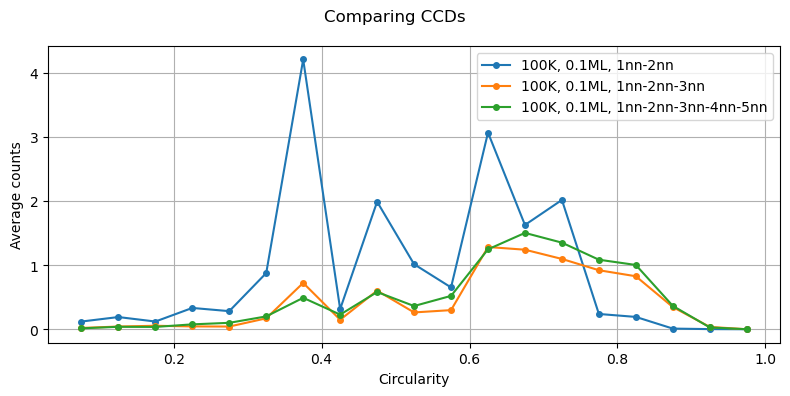

In [86]:
plot_ccds(df, temperature=[100], cov=[0.1], ints=sorted(set(df.int))[1:-1], overlay=True)

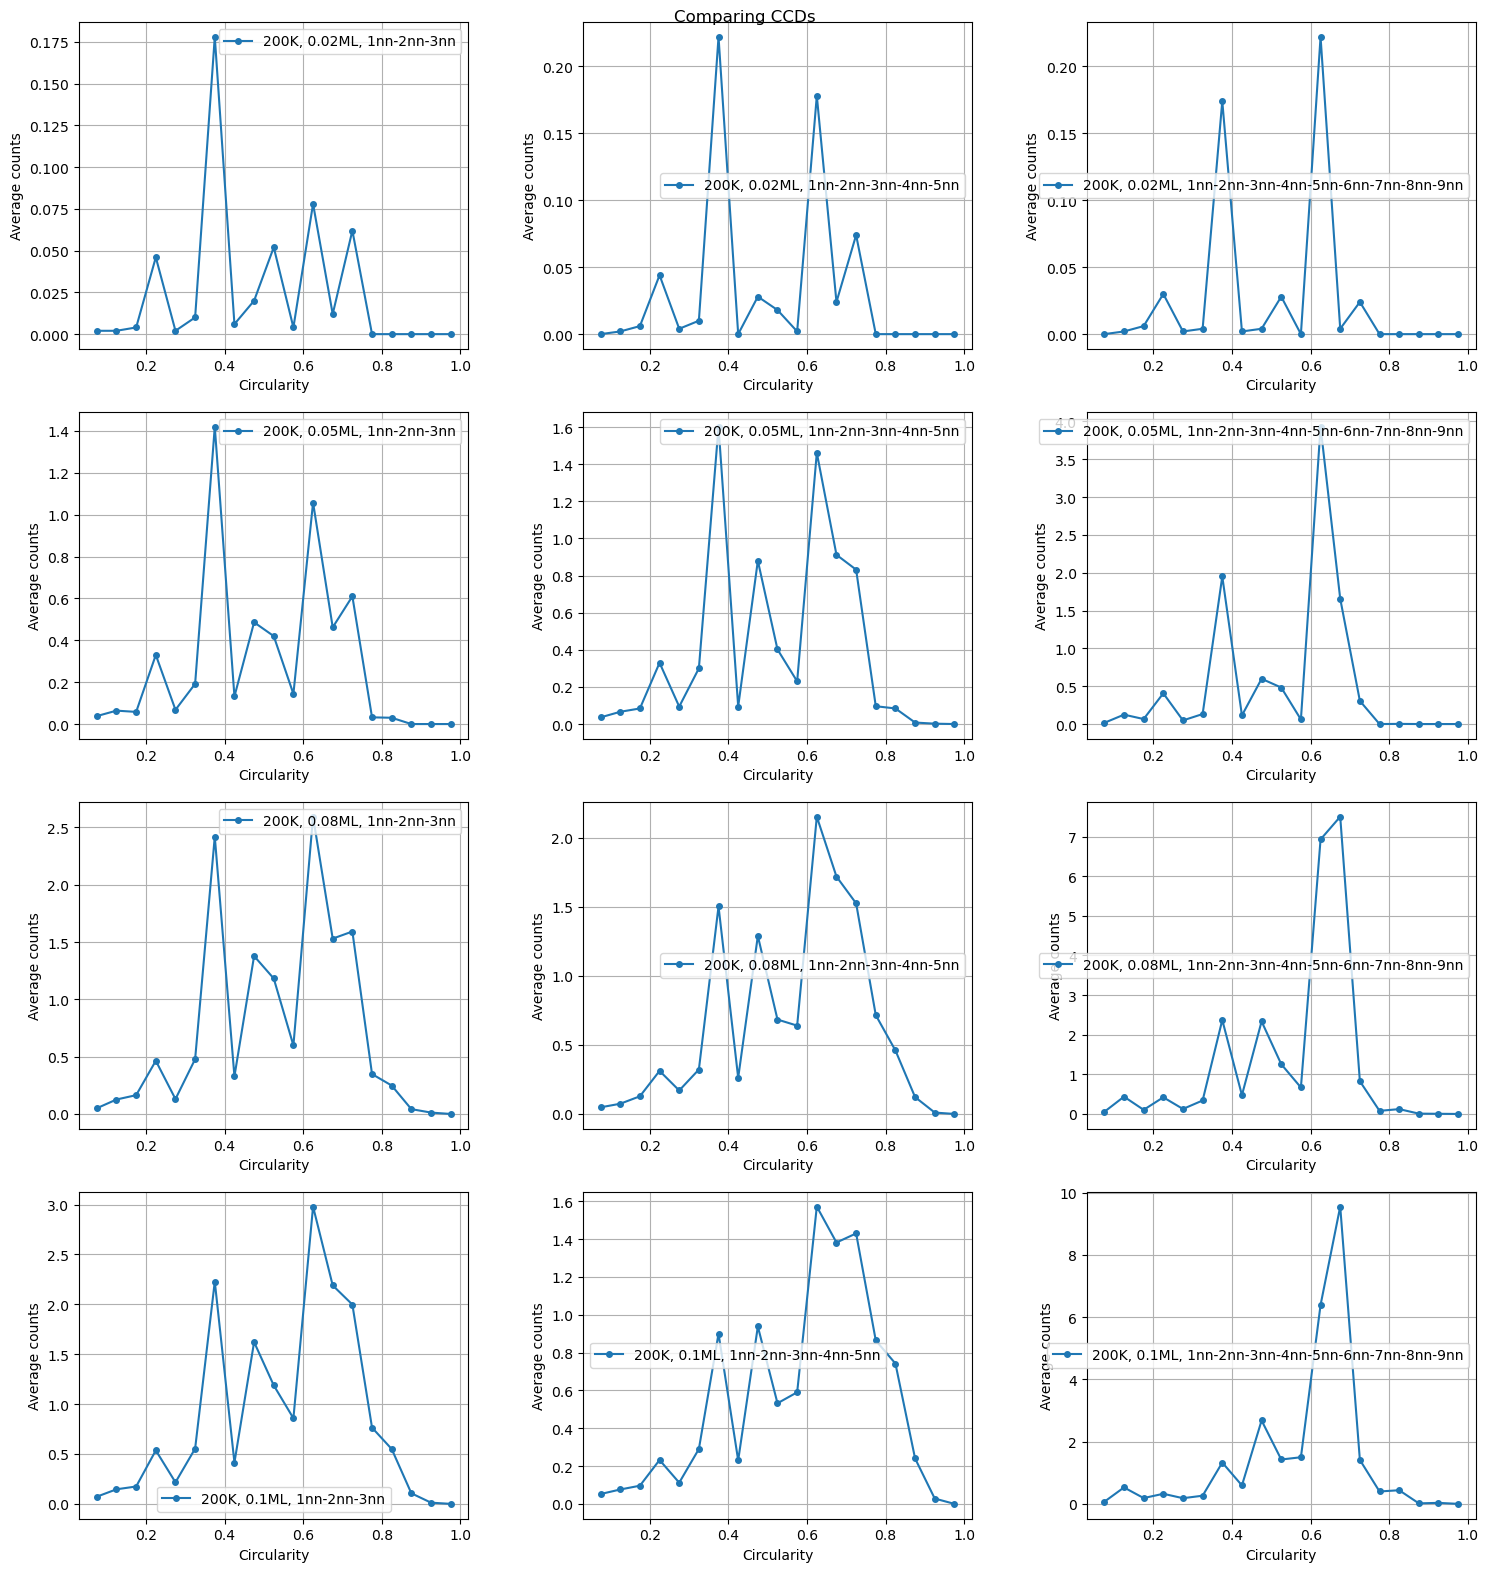

In [83]:
plot_ccds(df, temperature=[200], cov=sorted(set(df.nads/df.latsize.iloc[0])), ints=sorted(set(df.int))[2:], overlay=False)

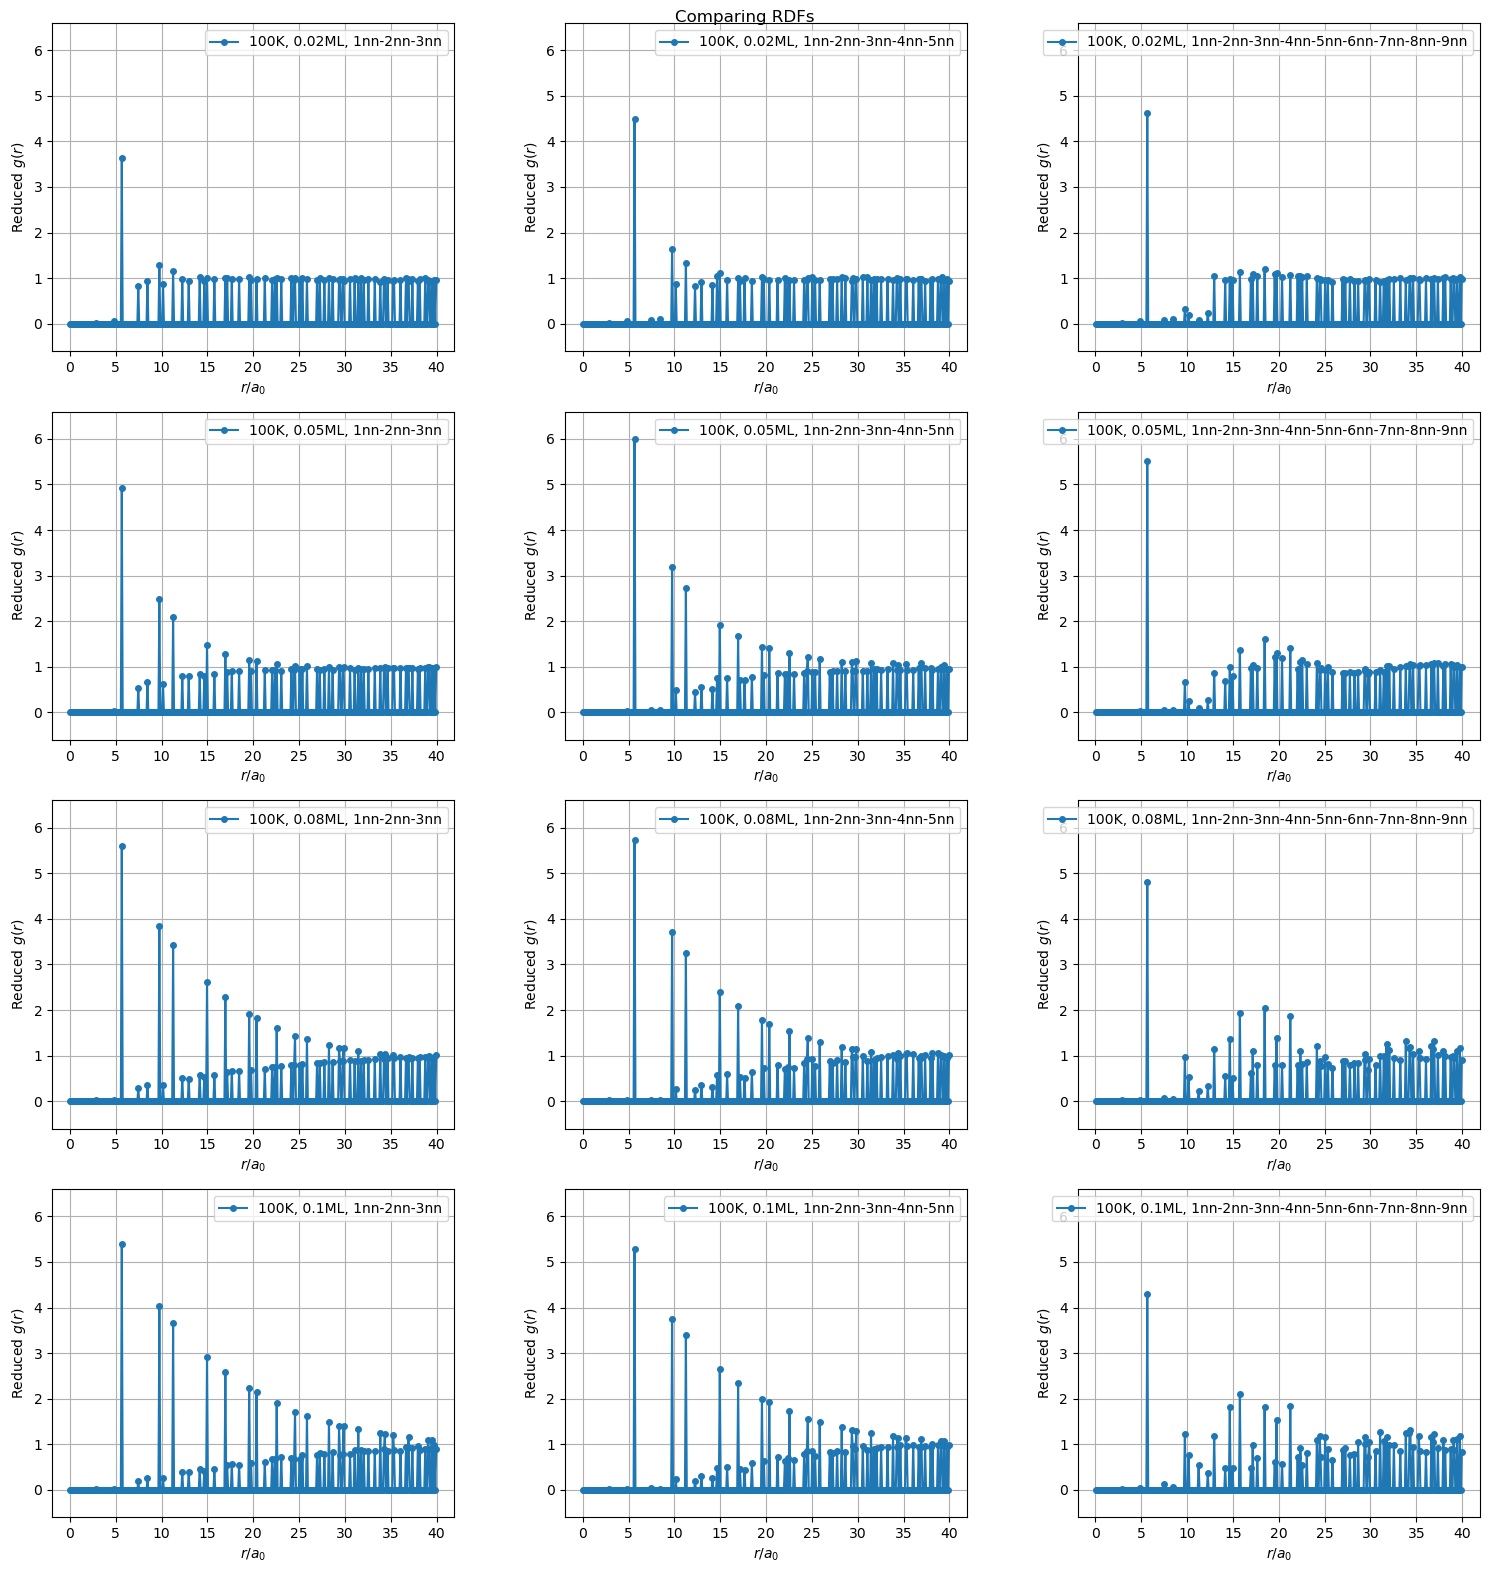

In [65]:
plot_rdfs(df, temperature=[100], cov=sorted(set(df.nads/df.latsize.iloc[0])), ints=sorted(set(df.int))[2:], overlay=False)

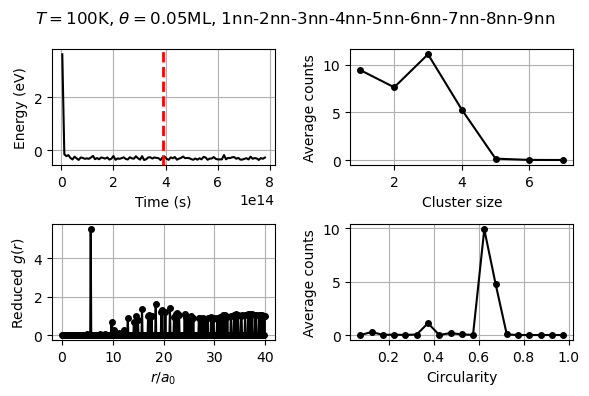

In [66]:
rundir = zf.plot_avgs(df, temperature=100, cov = 0.05, int='9nn',fraction_eq=fraction_eq,figsize=(6,4))

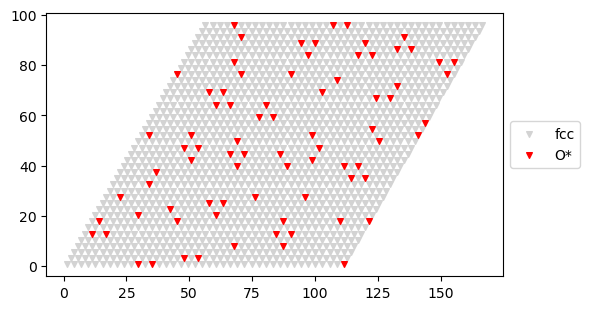

In [69]:
zf.lattice_plot(rundir / 'traj_2/lattice_input.dat',figsize=(6,4))